In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import time
from IPython import display
from tensorflow.keras.utils import Sequence
from keras import backend as K
import random
import segmentation_models as sm
sm.set_framework('tf.keras')
import pydot
import graphviz
from keras.utils import plot_model


'''os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"
os.environ["OMP_NUM_THREADS"]= "32"
tf.config.threading.set_intra_op_parallelism_threads(32)
tf.config.threading.set_inter_op_parallelism_threads(2)'''

ImportError: cannot import name 'plot_model' from 'keras.utils' (/home/hgamarro/anaconda3/envs/deeplearningDB/lib/python3.9/site-packages/keras/utils/__init__.py)

In [7]:
class DataGenerator(Sequence):
    def __init__(self, list_IDs,label_map , img_dir ,mode):
        'Initialization'
        self.list_IDs = list_IDs
        self.label_map = image_label_map
        self.on_epoch_end()
        self.img_dir = img_dir + "/images"
        self.mask_dir = img_dir + "/masks"
        self.mode = mode

    def __len__(self):
        return int(len(self.list_IDs))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index:(index+1)]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y    
    
    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""
        if self.mode == "train":
            # Generate data
            X, y = self.load_file(list_IDs_temp)
            return X, y
        elif self.mode == "val":
            X, y = self.load_file(list_IDs_temp)
            return X, y        
        
    def load_file(self, id_list):
        list_IDs_temp = id_list
        for ID in list_IDs_temp:
            x_file_path = os.path.join(self.img_dir, ID)
            y_file_path = os.path.join(self.mask_dir, self.label_map.get(ID))
            # Store sample
            X = np.load(x_file_path)
            #X = np.int64(X*255)
            # Store class
            y = np.load(y_file_path).astype('float32')
        return X, y

In [8]:
out_train_data_dir = '/home/hgamarro/DeepLearning/HG_space/data/processed/Vegas/train'
out_val_data_dir = '/home/hgamarro/DeepLearning/HG_space/data/processed/Vegas/val'


# ====================
# train set
# ====================
all_files = [s for s in os.listdir(out_train_data_dir + "/images/") if s.endswith('.npy')]
all_files.append([s for s in os.listdir(out_train_data_dir + "/masks/") if s.endswith('.npy')] )

image_label_map = {
        "image_file_{}.npy".format(i+1): "label_file_{}.npy".format(i+1)
        for i in range(int(len(all_files)))}
partition = [item for item in all_files if "image_file" in item]

# ====================
# validation set
# ====================
all_val_files = [s for s in os.listdir(out_val_data_dir + "/images/") if s.endswith('.npy')]
all_val_files.append([s for s in os.listdir(out_val_data_dir + "/masks/") if s.endswith('.npy')] )
val_image_label_map = {
        "image_file_{}.npy".format(i+1): "label_file_{}.npy".format(i+1)
        for i in range(int(len(all_val_files)))
}
val_partition = [item for item in all_val_files if "image_file" in item]


#train_generator = DataGenerator(partition,image_label_map,out_train_data_dir, "train")
#val_generator= DataGenerator(val_partition,val_image_label_map,out_val_data_dir, "val")

In [9]:
#re ,inp = load(PATH+'train/100.jpg')
#flips mask and input image
re_inp = DataGenerator(partition
                       ,image_label_map
                       ,out_train_data_dir
                       , "train")
val_re_inp= DataGenerator(val_partition
                          ,val_image_label_map
                          ,out_val_data_dir
                          , "val")

In [10]:
inp3 =  re_inp[4][1][14,:,:,:]

In [11]:
inp =  re_inp[4][0][14,:,:,:]

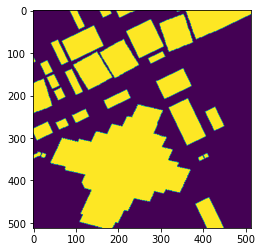

In [12]:
plt.imshow(inp3)

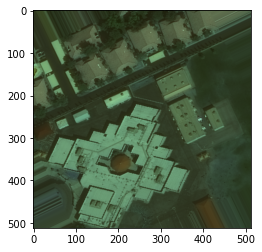

In [13]:
plt.imshow(inp)

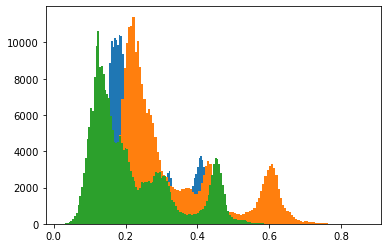

In [14]:
#fig, axes = plt.subplots(1, 3)#, figsize=(16, 5))
for a in np.arange(0,3):
    rng = inp[:,:,a]
    rng = rng.reshape(rng.shape[0]*rng.shape[1])
    plt.hist(rng, bins='auto')
    plt.show

In [15]:
type(inp)

numpy.ndarray

In [16]:
OUTPUT_CHANNELS = 1
K.clear_session()

def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', 
                                      kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

model_andor_weight_path = "/home/hgamarro/DeepLearning/JB_space/models/pix2pix/"
down_model = downsample(3, 4) 
#uses mask as input

In [17]:
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)
down_model.save(model_andor_weight_path+"_down_model4.h5")
down_model.summary()

(1, 256, 256, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (1, 256, 256, 3)          144       
_________________________________________________________________
batch_normalization (BatchNo (1, 256, 256, 3)          12        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (1, 256, 256, 3)          0         
Total params: 156
Trainable params: 150
Non-trainable params: 6
_________________________________________________________________


In [18]:
K.clear_session()

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [19]:
up_model = upsample(3, 4)

In [20]:
up_result = up_model(down_result)
print (up_result.shape)
if os.path.isdir(model_andor_weight_path):
    up_model.save(model_andor_weight_path+"_up_model4.h5")

(1, 512, 512, 3)


In [21]:
K.clear_session()

def Generator():
    inputs = tf.keras.layers.Input(shape=[512, 512, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        #downsample(64, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        #upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

Generator().summary()
generator = Generator()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256, 256, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128, 128, 128 131584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 64, 64, 256)  525312      sequential_1[0][0]               
______________________________________________________________________________________________

In [22]:
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
generator.save(model_andor_weight_path+"_generator4.h5")
gen_output = generator(inp[tf.newaxis, ...], training=False)
#gen_output = Generator_loop_mask(inp)

(1, 512, 512, 1)


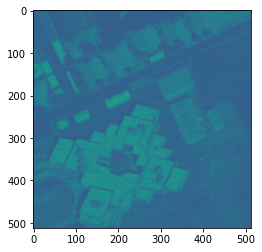

In [53]:
plt.imshow(gen_output[0, ...])
print(gen_output.shape)

In [24]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [25]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [26]:
K.clear_session()

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=(512, 512, 3), name='input_image')
    tar = tf.keras.layers.Input(shape=(512, 512, 1), name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

    down1 = downsample(128, 4, False)(x)  # (bs, 128, 128, 64)
   # down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down1)  # (bs, 128, 128, 64)
   # down4 = downsample(512, 4)(down3)  # (bs, 64, 64, 128)
   # down5 = downsample(256, 4)(down4)  # (bs, 32, 32, 256)
   # down6 = downsample(512, 4)(down5)  # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 3, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()
#tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)
discriminator.summary()
discriminator.save(model_andor_weight_path+"_discriminator4.h5")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 512, 512, 4)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256, 256, 128 8192        concatenate[0][0]            

In [27]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
#disc_out = discriminator([inp, gen_output], training=False)

(1, 127, 127, 1)


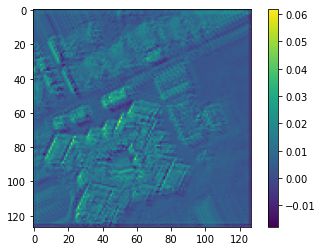

In [28]:
plt.imshow(disc_out[0, ..., -1]#, vmin=-20, vmax=20
   # , cmap='RdBu_r'
          )
plt.colorbar()
print(disc_out.shape)

In [29]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [30]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [207]:
def IOUscore(tar ,pred):
    bool_tar = np.array(test_mask ,dtype=bool)
    bool_pred = np.array(tf.math.greater(pred ,.5))
    #bool_pred = np.array(tf.math.greater(pred ,.5))
    
    intersection = bool_tar * bool_pred
    union = bool_tar + bool_pred
    print(intersection.sum() / union.sum())
    return intersection.sum() / union.sum()

In [208]:
def generate_images(model, test_input, tar ,epoch):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']   
        
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()
    
    iou_score = IOUscore(test_input ,prediction)

    with summary_writer.as_default():
        tf.summary.scalar('iou_score', iou_score, step=epoch)

In [55]:
test_gen

[11.0, 22.0, 0.0, 44.0, 34.0, 0.0, 0.0]

In [56]:
test_gen = [11. ,22. ,0., 44. ,34. ,0. ,0.]
test_val = [11. ,0. ,0., 44. ,0. ,0. ,3.]
max_ = argmax(test_gen ,test_val)
loss_object(tf.ones_like(test_gen) ,test_gen)

NameError: name 'argmax' is not defined

In [205]:
i=random.randint(0,bs1-1)
j=random.randint(0,bs2-1)
pred = generator(val_re_inp[i][0][tf.newaxis ,j,...], training=True)
pred = pred[0]
test_inp = val_re_inp[i][0][j ,...]
test_mask =  val_re_inp[i][1][j ,...]
print(test_inp.shape ,test_mask.shape ,pred.shape )

(512, 512, 3) (512, 512, 1) (512, 512, 1)


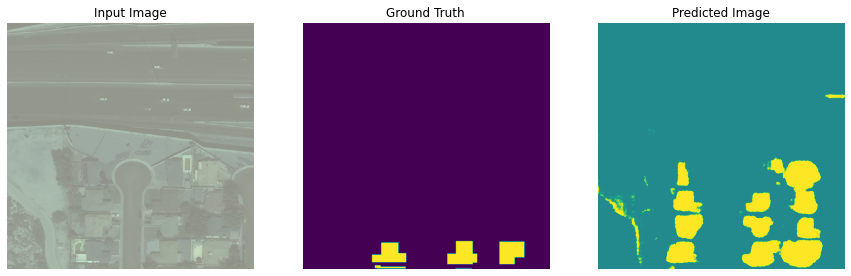

0.21289257335488976


In [209]:
generate_images( generator
               # ,tf.cast(test_ds[i][0][tf.newaxis ,j,:,:,:], tf.float32)
                #,tf.cast(test_ds[i][1][tf.newaxis ,j,:,:,:], tf.float32)
                ,val_re_inp[i][0][tf.newaxis ,j ,...]
                ,val_re_inp[i][1][tf.newaxis ,j ,...]
                 ,1                 ) 

In [122]:
np.histogram(test_inp)

(array([ 21899, 225329, 345143, 140226,  38549,  10685,   2763,   1321,
           379,    138]),
 array([0.        , 0.09058823, 0.18117647, 0.2717647 , 0.36235294,
        0.45294118, 0.5435294 , 0.63411766, 0.7247059 , 0.81529415,
        0.90588236], dtype=float32))

In [156]:
np.histogram(test_mask)

(array([191949,      0,      0,      0,      0,      0,      0,      0,
             0,  70195]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32))

In [161]:
np.histogram(pred)

(array([    27,    116,    349,    995, 191164,   3463,   1271,   1132,
          1329,  62298]),
 array([-0.96337765, -0.7670399 , -0.57070214, -0.37436435, -0.17802659,
         0.01831117,  0.21464893,  0.4109867 ,  0.6073245 ,  0.80366224,
         1.        ], dtype=float32))

In [128]:
type(test_mask)

numpy.ndarray

In [183]:
type(pred)

tensorflow.python.framework.ops.EagerTensor

In [142]:
test_mask.shape

(512, 512, 1)

In [202]:
np.histogram( test_mask )

(array([191949,      0,      0,      0,      0,      0,      0,      0,
             0,  70195]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32))

In [191]:
bool_mask = np.array(test_mask ,dtype=bool)
np.histogram( bool_mask )

(array([191949,      0,      0,      0,      0,      0,      0,      0,
             0,  70195]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [196]:
bool_mask.shape

(512, 512, 1)

In [199]:
bool_pred = np.array(tf.math.greater(pred ,.5))
np.histogram( bool_mask )

(array([191949,      0,      0,      0,      0,      0,      0,      0,
             0,  70195]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [200]:
bool_pred.shape

(512, 512, 1)

In [195]:
pred.shape

TensorShape([512, 512, 1])

In [ ]:
np.histogram( np.array(bool_pred ,dtype=bool) )

In [188]:
intersection = bool_mask1 * bool_pred
union = bool_mask1 + bool_pred
IOU = intersection.sum() / union.sum()
IOU

0.2677726745605469

In [201]:
intersection = bool_mask * bool_pred
union = bool_mask + bool_pred
IOU = intersection.sum() / union.sum()
IOU

0.6964148252842522

In [86]:
pred_map = map(int,pred)
test_map = map(int,test_mask)

In [87]:
set(pred_map)|set(test_map)

TypeError: only size-1 arrays can be converted to Python scalars

In [81]:
np.histogram(test_mask.intersection(pred))

AttributeError: 'numpy.ndarray' object has no attribute 'intersection'

In [32]:
test_dataset = re_inp[0][0][0,:,:,:]

In [33]:
for i in np.arange(len(re_inp) -90):
    for j in np.arange(re_inp[i][0][:,:,:,:].shape[0] -31):
        print( re_inp[i][1][j,:,:,:].shape)
        print( re_inp[i][0][j,:,:,:].shape)

(512, 512, 1)
(512, 512, 3)


In [34]:
inp3.shape

(512, 512, 1)

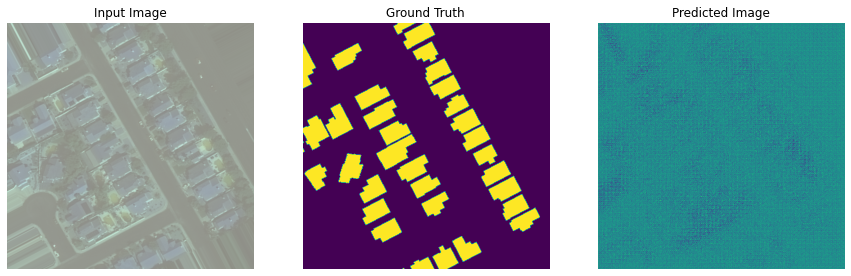

In [35]:
for i in np.arange(len(re_inp) -90):
    for j in np.arange(re_inp[i][0][:,:,:,:].shape[0] -31):
        generate_images( generator
                        , re_inp[i+52][0][tf.newaxis ,j,:,:,:]
                        , re_inp[i+52][1][tf.newaxis ,j,:,:,:])
        #print(re_inp[i][1][tf.newaxis ,j,:,:,:]).shape

In [36]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [109]:
model_andor_weight_path = "/home/hgamarro/DeepLearning/JB_space/models/pix2pix/"
checkpoint_dir = model_andor_weight_path+'logs/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
log_dir=model_andor_weight_path+"logs/"
summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

In [38]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        #print(gen_output.shape)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

trainstep = train_step(re_inp[0][0][np.newaxis ,1,...] ,re_inp[0][1][np.newaxis ,1,...] ,1)
type(trainstep)
del trainstep

#this actually works to train
for input_image, target in zip(re_inp[i][0][tf.newaxis ,j,:,:,:]
                            ,re_inp[i][1][tf.newaxis ,j,:,:,:]):
    print(input_image.shape)
    print(type(input_image))
    print(target.shape)
    print(type(tf.cast(target, tf.float32)))
    train_step(tf.cast(input_image[tf.newaxis ,...] , tf.float32)
               , tf.cast(target[tf.newaxis ,...], tf.float32)
               , epoch=1
              )

if not os.path.isfile(model_andor_weight_path+"model_pix2pix_generator_trained2.h5"):
	generator.save(model_andor_weight_path+"model_pix2pix_generator_trained2.h5")
if not os.path.isfile(model_andor_weight_path+"model_pix2pix_discriminator_trained2.h5"):
	discriminator.save(model_andor_weight_path+"model_pix2pix_discriminator_trained2.h5")

In [39]:
print("val_re_inp/test_ds len: " ,len(val_re_inp))

val_re_inp/test_ds len:  23


In [40]:
datetime.now() - datetime.now()

datetime.timedelta(days=-1, seconds=86399, microseconds=999998)

In [41]:
print(re_inp[0][0][:,:,:,:].shape[0])
print(len(re_inp))

32
91


In [42]:

bs2 = re_inp[0][0][:,:,:,:].shape[0]
bs1 = len(re_inp)
for batch in [85]:     
    for row in range( re_inp[batch][0][...].shape[0] ):
        #if (row >9) & (row < 13):
        print(batch ,"," ,row)
        print( re_inp[batch][0][row,...].shape[0]
                             #,len(train_ds)[1].shape
             )
        
'''for inp_mask in train_ds:
    for batch in zip(inp_mask[0] , inp_mask[1]):
        print('.', end='')'''
        

85 , 0
512
85 , 1
512
85 , 2
512
85 , 3
512
85 , 4
512
85 , 5
512
85 , 6
512
85 , 7
512
85 , 8
512
85 , 9
512
85 , 10
512


"for inp_mask in train_ds:\n    for batch in zip(inp_mask[0] , inp_mask[1]):\n        print('.', end='')"

In [43]:
def Fit(train_ds, epochs, test_ds):
    #bs2 = train_ds[0][0][:,:,:,:].shape[0]
    bs1 = len(train_ds)
    '''bs2_ = test_ds[0][0][:,:,:,:].shape[0]
    bs1_ = len(test_ds)'''
    
    for epoch in range(epochs):
        #start1 = time.time()
        start = datetime.now()
        print("start: " ,start)
        
        for batch in range( bs1 ):        
            for row in range( train_ds[batch][0][...].shape[0] ):
                print('.' , row , end='')
                img_masks = (train_ds[batch][0][row,...] 
                             ,train_ds[batch][1][row,...])
                if (epoch) % 1 == 0:                
                    train_step( epoch=epoch
                               , input_image = img_masks[0][tf.newaxis ,...]
                               , target = img_masks[1][tf.newaxis ,...]
                                        )
           
            print("-finished a training batch-"+str(epoch+1)+"_"+str(batch+1) ,'-' ,datetime.now() , end='\n')
            
            '''i=random.randint(0,bs1_)
            j=random.randint(0,bs2_)
            generate_images( generator
                            ,test_ds[i][0][tf.newaxis ,j,:,:,:]
                            ,test_ds[i][1][tf.newaxis ,j,:,:,:]''' 
            if batch % 45 == 0:
            #if (epoch+1) % 10 == 0:
                checkpoint.save(file_prefix=checkpoint_prefix+'_epoch_batch:'+str(epoch+1)+"_"+str(batch+1) )
            #print("\n---------------------------------------------Epoch: ", epoch)

        end = datetime.now()
        print("end: " ,end='\n')
        print("\nTime Taken for epoch: %s" % (end-start))
           
    checkpoint.save(file_prefix=checkpoint_prefix+'_epoch_batch:'+str(epoch+1)+"_"+str(batch+1) )

    # saving (checkpoint) the model every 20 epochs
    #if (epoch + 1) % 2 == 0:
        #checkpoint.save(file_prefix=checkpoint_prefix)

In [40]:
EPOCHS = 2
Fit(re_inp
    , EPOCHS
    , val_re_inp)

start:  2021-05-12 09:45:26.680133
. 0. 1. 2. 3. 4

KeyboardInterrupt: 

In [ ]:
for epoch in range(10):
    print(epoch+1)

In [ ]:
re_inp[0][1].shape

In [ ]:
for epoch in range(150):
    bs2 = re_inp[0][0][:,:,:,:].shape[0]
    bs1 = len(re_inp)

    for batch in range(bs1-1):        
        for row in range(bs2-1):
            img_masks = (re_inp[batch][0][row,...] 
                         ,re_inp[batch][1][row,...])
            if (epoch) % 1 == 0:                
                print(img_masks[0].shape)
                print(img_masks[1].shape)
                print(batch)
                print(row)
                generate_images(model = generator
                                ,test_input = img_masks[0][tf.newaxis ,...]
                                ,tar = img_masks[1][tf.newaxis ,...]
                               )

In [57]:
checkpoint_dir

'/home/hgamarro/DeepLearning/JB_space/models/pix2pix/logs/training_checkpoints'

In [63]:
checkpoint.restore(tf.train.latest_checkpoint('/home/hgamarro/DeepLearning/JB_space/models/pix2pix/logs0510/training_checkpoints'))

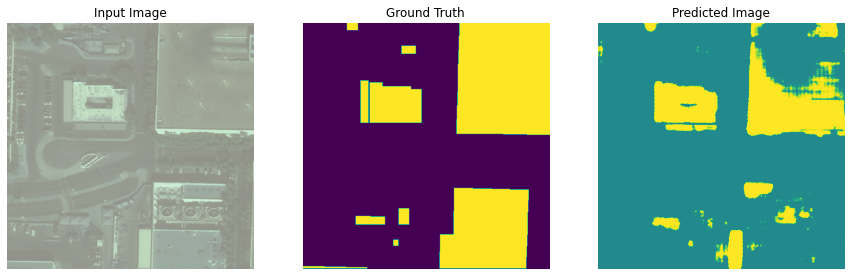

TensorShape([1, 512, 512, 1])

In [66]:
bs2 = val_re_inp[0][0][:,:,:,:].shape[0]
bs1 = len(val_re_inp)

i=random.randint(0,bs1-1)
j=random.randint(0,bs2-1)
generate_images( generator
               # ,tf.cast(test_ds[i][0][tf.newaxis ,j,:,:,:], tf.float32)
                #,tf.cast(test_ds[i][1][tf.newaxis ,j,:,:,:], tf.float32)
                ,val_re_inp[i][0][tf.newaxis ,j,...]
                ,val_re_inp[i][1][tf.newaxis ,j,...]
                    ) 
pred = generator(val_re_inp[i][0][tf.newaxis ,j,...], training=True)
pred.shape

In [68]:
np.histogram(pred[0])

(array([    18,     59,    159,    488, 212626,   3308,   1579,   1367,
          1584,  40956]),
 array([-0.90279424, -0.7125148 , -0.5222354 , -0.33195597, -0.14167655,
         0.04860288,  0.2388823 ,  0.42916173,  0.61944115,  0.8097206 ,
         1.        ], dtype=float32))

In [56]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [18]:
%tensorboard --logdir '/home/hgamarro/DeepLearning/JB_space/models/pix2pix/logs0507/fit/'

In [35]:
os.getcwd()

'/home/hgamarro/DeepLearning/JB_space/notebooks/scratch'